In [3]:
from __future__ import print_function
import cv2 as cv
import numpy as np
import argparse
import matplotlib.pyplot as plt
import time
import cv2
import math
from PIL import Image
plt.rcParams['figure.figsize'] = 15, 10

# 处理填空题

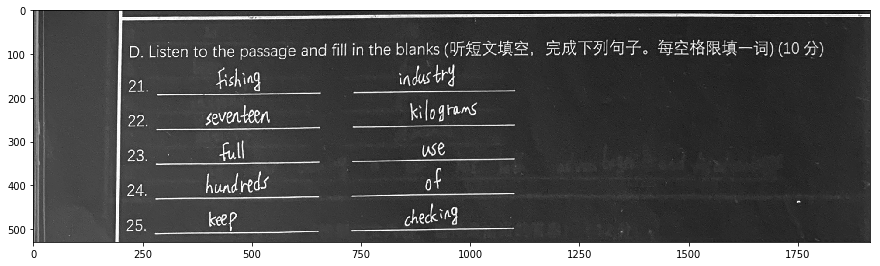

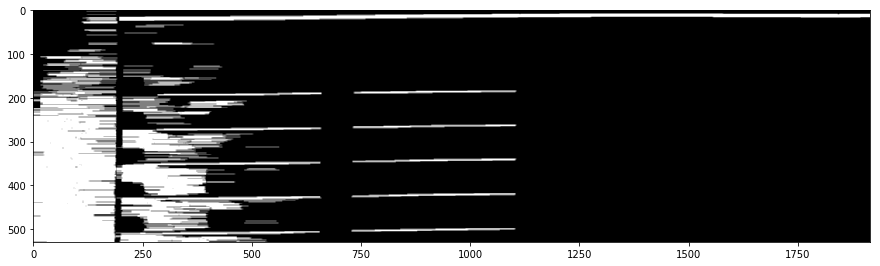

(530, 1916)
101


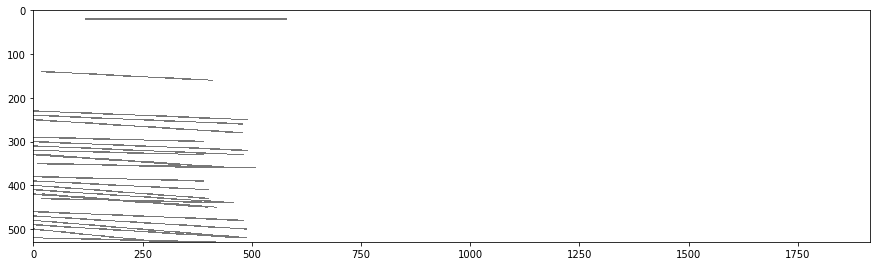

[[120  20 460   0  24]
 [ 20 140 390  20  20]
 [  0 230 490  20  25]
 [  0 240 480  20  25]
 [  0 250 480  30  25]
 [  0 290 390  10  20]
 [  0 300 490  20  25]
 [  0 310 480  20  25]
 [  0 320 390  10  20]
 [  0 330 450  30  23]
 [ 20 330 440  30  22]
 [ 10 350 420  10  21]
 [ 20 350 490  10  25]
 [  0 380 390  10  20]
 [  0 390 400  20  20]
 [  0 400 400  30  20]
 [  0 410 460  30  24]
 [  0 420 400  30  20]
 [ 20 420 400  30  20]
 [ 20 430 430  10  22]
 [  0 460 480  20  25]
 [  0 470 490  30  25]
 [  0 480 490  40  25]
 [  0 490 480  30  25]
 [  0 500 400  40  20]
 [  0 520 440  10  22]
 [ 70 530 390  10  20]]


In [332]:
# https://www.cnblogs.com/korbin/p/5625340.html
import math
DEBUG = True
img = cv2.imread('/home/hecong/image/fill_4.jpg') 
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# horizontal_size = int(img.shape[1] * 0.2)
# horizontalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 1))
img = cv2.bitwise_not(img)

plt.imshow(img,'gray')
plt.show()
# _,img = cv2.threshold(img, 100, 255,  cv2.THRESH_OTSU + cv2.THRESH_BINARY)
_,img = cv2.threshold(img, 100, 255,  cv2.THRESH_BINARY)

horizontalStructure = cv2.getStructuringElement(cv2.MORPH_CROSS, (60, 1))
img = cv2.erode(img, horizontalStructure)  # 先腐蚀
img = cv2.dilate(img, horizontalStructure) # 再膨胀

img = cv2.blur(img, tuple((4,4)))
# img = cv2.GaussianBlur(img,(5,5),0)
# img = cv2.medianBlur(img,3)

plt.imshow(img,'gray')
plt.show()

# img = cv2.dilate(img, None, iterations=1)

# img = cv2.bitwise_not(img)
# img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, \
#                                 cv2.THRESH_BINARY, 15, -2)

# img = cv2.bitwise_not(img)

print(img.shape)
# 扫线最小长度取图片的宽 20%长度
minLineLength = int(img.shape[1] * 0.2)

lines = cv2.HoughLinesP(img, 1, np.pi / 180, 40, minLineLength=minLineLength, maxLineGap=60)


imgcanv = Image.new("RGB", (img.shape[1], img.shape[0]), (255, 255, 255))
imgcanv = np.array(imgcanv)
lines = lines[:,0,:]
exmr = []
for line in lines:
    x1, y1, x2, y2 = line
    width = abs(x2-x1)
    hight = abs(y2-y1)
    x1,y1,width,hight = int(10*round(x1/10)), int(10*round(y1/10)), int(10*round(width/10)), int(10*round(hight/10))
    if int(100 * width/img.shape[1]) <= 25 and int(100 * width/img.shape[1]) >= 20:
        # 进行四舍五入操作,为后期排重做准备
        exmr.append([x1,y1,width,hight,int(100 * width/img.shape[1])])
        
exmr = np.array(exmr)
print(len(exmr))
# 根据Y轴进行排重
va,inx = np.unique(exmr[:,1] + exmr[:,0],return_index=True)
exmr = exmr[inx]

exmr = exmr[exmr[:,2]>200]
idex = np.lexsort([exmr[:, 0], exmr[:, 1]])


exmr = exmr[idex,:]
# cidx = [0,3,4,6,9,10,11,14,16,18,20]
# exmr = exmr[cidx,:]

# print(exmr)
if DEBUG:
    for item in exmr:
        x1,y1,w,h,s = item
        cv2.line(imgcanv, (x1, y1), (x1+w, y1+h), (120, 120, 120), 2)
        
if DEBUG:
#     logger.debug('调试，显示划线图')
    plt.imshow(imgcanv,'gray')
    plt.show()

print(exmr)
# plt.imshow(img,'gray')
# plt.show()
# print(exmr)

In [333]:

# 根据Y轴取维一的值 
# print(exmr)
v = np.unique(exmr[:,1])
print(v[1:])
# 去掉Y轴相近的值，得到分组的基本值
vv = [x for i,x in enumerate(v[1:]) if abs(x-v[i])> 10 ]
vv.insert(0,v[0])
print(vv)
# 根据分组的基本值，得到相应的索引位值,  再对比X轴的值，去掉相近的值
groups = []
for item in vv:
    idx =np.where(abs(exmr[:,1]-item) <= 10)[0]
    if(len(idx)>1):
        # 因为X轴已按从小到大排序，所以可以利用其特点按序进行检测
        xidxs = [idx[0]]
#         current = idx[0]
        for xitem in idx[1:]:
            
            if np.all(abs(exmr[xidxs,0] - exmr[xitem,0]) > 20):
                xidxs.append(xitem)
                current = xitem
        
        groups.append([item,xidxs])
    else:
        groups.append([item,idx.tolist()])

print(groups)

gp = [x[1] for x in groups]
print(gp)
cc = np.array(gp)
# print(cc.reshape(-1))
# cidx = [0,3,4,6,9,10,11,14,16,18,20]
# print(exmr)
# print(exmr[cidx])



[140 230 240 250 290 300 310 320 330 350 380 390 400 410 420 430 460 470
 480 490 500 520 530]
[20, 140, 230, 290, 350, 380, 460, 520]
[[20, [0]], [140, [1]], [230, [2]], [290, [5]], [350, [11]], [380, [13]], [460, [20]], [520, [25, 26]]]
[[0], [1], [2], [5], [11], [13], [20], [25, 26]]


# 识别试卷中心区域

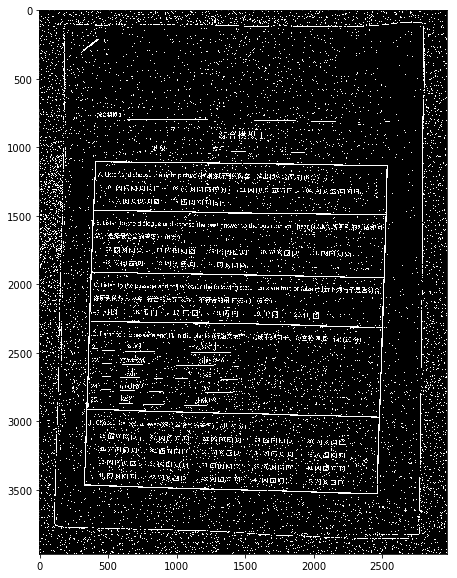

66300
[5455.5, 15434.0, 3942666.5, 1370470.0, 746804.0, 948913.0, 745051.5, 7128.0, 7819.5, 25905.0]


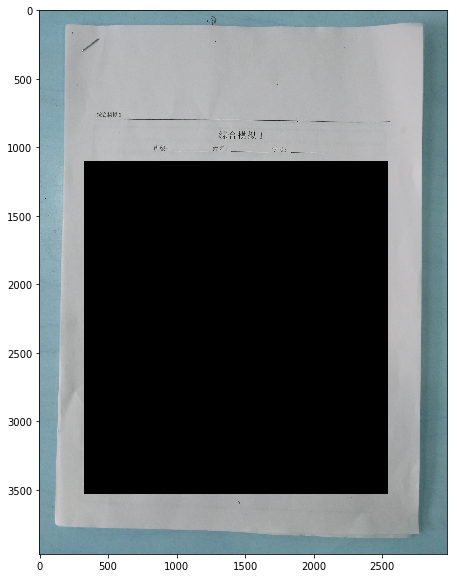

In [40]:
# https://blog.csdn.net/keith_bb/article/details/53470170?utm_source=blogxgwz0  华为荣耀V10 小米max1

imgage = cv2.imread('/home/hecong/image/华为荣耀V8.jpg',cv2.IMREAD_COLOR)
img = cv2.cvtColor(imgage,cv2.COLOR_BGR2GRAY)
img = cv2.GaussianBlur(img,(5,5),0)
# ret,img = cv2.threshold(img,0,255,cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV,11,2)
# img = cv2.blur(img,tuple((5,5)))
plt.imshow(img,'gray')
plt.show()
nimg, contours, hierarchy = cv2.findContours(
    img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
print(len(contours))
rcnt = []
rarea = []
for cnt in contours:
    if cv2.contourArea(cnt) > 5000:
        rarea.append(cv2.contourArea(cnt))
        rcnt.append(cnt)
print(rarea)        
pos = np.argmax(rarea)        
cnt = rcnt[pos]
x,y,w,h = cv2.boundingRect(cnt)
cv2.rectangle(imgage,(x,y),(x+w,y+h),0,-1)
plt.imshow(imgage,'brg')
plt.show()

# 识别试卷边框

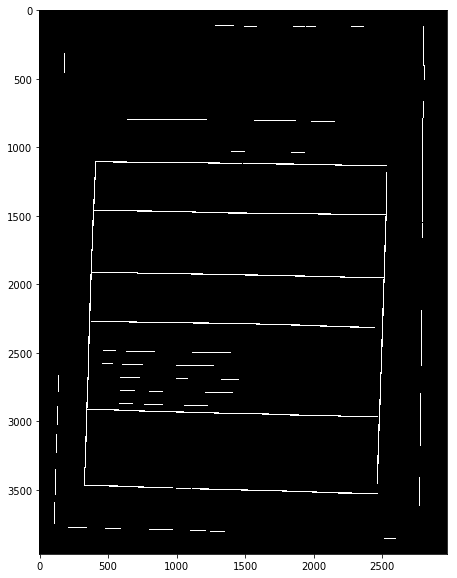

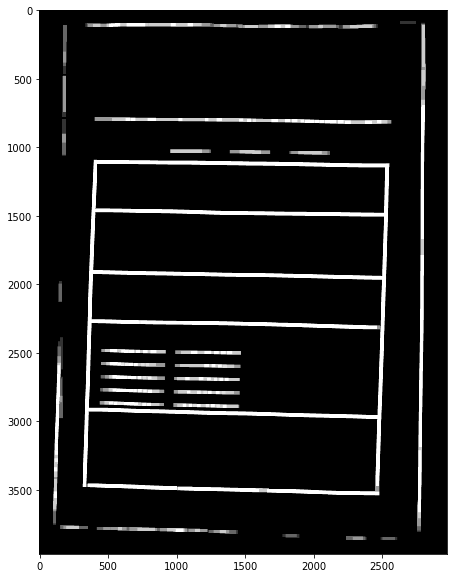

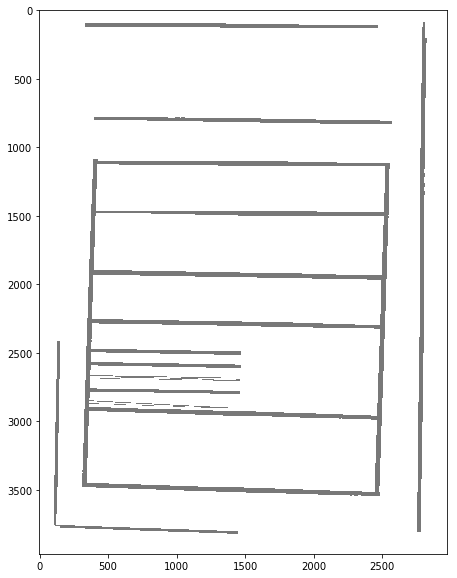

In [41]:
DEBUG = True

def _get_rect(image):
        image = cv2.blur(image, tuple((5, 5)))
        element = cv2.getStructuringElement(cv2.MORPH_RECT, tuple((21, 21)), (-1, -1))
        imgr = cv2.dilate(image, element, iterations=1)
        if DEBUG:
#             logger.debug('调试，显示处理后合并图')
            plt.imshow(imgr,'gray')
            plt.show()

        lines = cv2.HoughLinesP(imgr, 1, np.pi / 180, 20, minLineLength=1000, maxLineGap=80)
        if DEBUG:
            imgt = Image.new("RGB", (imgr.shape[1], imgr.shape[0]), (255, 255, 255))
            imgt = np.array(imgt)
        lines = lines[:,0,:]
        exmr = []
        for line in lines:
            x1, y1, x2, y2 = line
            if DEBUG:
                cv2.line(imgt, (x1, y1), (x2, y2), (120, 120, 120), 2)
            width = abs(x2-x1)
            hight = abs(y2-y1)
            exmr.append([x1,y1,width,hight, sum((x1,y1,hight,width))])

        if DEBUG:
#             logger.debug('调试，显示划线图')
            plt.imshow(imgt,'gray')
            plt.show()

    



imgage = cv2.imread('/home/hecong/image/华为荣耀V8.jpg',cv2.IMREAD_COLOR)
img = cv2.cvtColor(imgage,cv2.COLOR_BGR2GRAY)
img = cv2.GaussianBlur(img,(5,5),0)
# ret,img = cv2.threshold(img,0,255,cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV,11,2)  # 11, 2 这两个参数有什么用 ？？

horizontal = np.copy(img)
vertical = np.copy(img)

cols = horizontal.shape[1]
horizontal_size = int(cols / 40)

# Create structure element for extracting horizontal lines through morphology operations
horizontalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (horizontal_size, 1))
# Apply morphology operations
horizontal = cv2.erode(horizontal, horizontalStructure)
horizontal = cv2.dilate(horizontal, horizontalStructure)

rows = vertical.shape[0]
verticalsize = int(rows / 40)
# Create structure element for extracting vertical lines through morphology operations
verticalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (1, verticalsize))

# Apply morphology operations
vertical = cv2.erode(vertical, verticalStructure)
vertical = cv2.dilate(vertical, verticalStructure)

nn = cv2.bitwise_or(vertical,horizontal)
plt.imshow(nn,'gray')
plt.show()

_get_rect(nn)
